In [1]:
# install RDKit for offline use
!pip install /kaggle/input/rdkit-install-whl/rdkit_wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/rdkit-install-whl/rdkit_wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [1]:
# Imports
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")

In [2]:
# --- Utility function to create grid from random best params
def create_grid_from_best(best_params, steps=3, percent=0.3):
    grid = {}
    for k, v in best_params.items():
        if isinstance(v, (int, float)):
            low = v * (1 - percent)
            high = v * (1 + percent)
            if isinstance(v, int):
                grid[k] = list(set([int(round(x)) for x in np.linspace(low, high, steps)]))
            else:
                grid[k] = np.linspace(low, high, steps)
        else:
            grid[k] = [v]
    return grid

In [3]:
# Load & prepare data
df = pd.read_csv('/kaggle/input/dataset-9may/dataset_9May.csv')
smiles = df.pop('Molecule')  # Optional: drop SMILES string

# Define targets
targets = ['gap','mu','alpha','homo','lumo','r2','zpve','U0','U','H','G','Cv']
features = [c for c in df.columns if c not in targets]

X = df[features].fillna(0)
Y = df[targets]

# Train/test split stratified by molecule size
atoms = [c for c in df.columns if len(c)==1 and c.isupper()]
size = df[atoms].sum(axis=1)
X_tr, X_te, Y_tr, Y_te = train_test_split(
    X, Y, test_size=0.2, random_state=42,
    stratify=pd.qcut(size, 5)
)


# Log transform for mu and r2 - training and test
Y_tr[['mu', 'r2']] = np.log1p(Y_tr[['mu', 'r2']])

In [4]:
# --- Preprocessing pipeline
pre = Pipeline([
    ('scale', StandardScaler()),
    ('var', VarianceThreshold(1e-5))
])

# --- Store predictions and models
preds = pd.DataFrame(index=X_te.index, columns=Y_tr.columns)
best_models = {}

# --- Ridge for U0, U, H, G, homo, r2
ridge_targets = ['U0', 'U', 'H', 'G', 'homo', 'r2']
for t in [['U0', 'U', 'H', 'G'], 'homo', 'r2']:
    is_multi = isinstance(t, list)
    t_name = ' + '.join(t) if is_multi else t
    print(f"\n🔍 {t_name.upper()} - Ridge")
    
    pipe = Pipeline([('pre', pre), ('model', 
             MultiOutputRegressor(Ridge()) if is_multi else Ridge())])
    param_grid = {'model__estimator__alpha': [0.001, 0.01, 0.1, 1, 10]} if is_multi else {
        'model__alpha': [0.001, 0.01, 0.1, 1, 10]
    }
    
    gs = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    gs.fit(X_tr, Y_tr[t] if is_multi else Y_tr[t])
    print(f"  🎯 Best (Grid): {gs.best_params_}")
    
    if is_multi:
        best_models['energies'] = gs
        preds[t] = gs.predict(X_te)
    else:
        best_models[t] = gs
        preds[t] = np.expm1(gs.predict(X_te)) if t in ['mu', 'r2'] else gs.predict(X_te)

# --- Settings for random search
pipe_rf = Pipeline([('pre', pre), ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])
pd_rf = {
    'model__n_estimators': randint(100, 600),
    'model__max_depth': randint(5, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': uniform(0.3, 0.7)
}

pipe_hgbr = Pipeline([('pre', pre), ('model', HistGradientBoostingRegressor(random_state=42))])
pd_hgbr = {
    'model__max_iter': randint(300, 800),
    'model__learning_rate': uniform(0.01, 0.15),
    'model__max_depth': randint(4, 12),
    'model__l2_regularization': uniform(0, 0.5)
}

# --- RF targets
for t in ['mu', 'lumo', 'zpve', 'Cv']:
    print(f"\n🔍 {t.upper()} - Random Forest")
    rs = RandomizedSearchCV(pipe_rf, pd_rf, n_iter=20, cv=3, scoring='neg_root_mean_squared_error',
                            n_jobs=-1, random_state=42)
    rs.fit(X_tr, Y_tr[t])
    print(f"  🔧 Best (Random): {rs.best_params_}")
    
    grid = create_grid_from_best(rs.best_params_, steps=3)
    gs = GridSearchCV(pipe_rf, grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    gs.fit(X_tr, Y_tr[t])
    best_models[t] = gs
    preds[t] = np.expm1(gs.predict(X_te)) if t in ['mu', 'r2'] else gs.predict(X_te)
    
    print(f"  🎯 Best (Grid): {gs.best_params_}")

# --- HGBR targets
for t in ['gap', 'alpha']:
    print(f"\n🔍 {t.upper()} - HGBR")
    rs = RandomizedSearchCV(pipe_hgbr, pd_hgbr, n_iter=30, cv=3, scoring='neg_root_mean_squared_error',
                            n_jobs=-1, random_state=42)
    rs.fit(X_tr, Y_tr[t])
    print(f"  🔧 Best (Random): {rs.best_params_}")
    
    grid = create_grid_from_best(rs.best_params_, steps=3)
    gs = GridSearchCV(pipe_hgbr, grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    gs.fit(X_tr, Y_tr[t])
    best_models[t] = gs
    preds[t] = gs.predict(X_te)
    
    print(f"  🎯 Best (Grid): {gs.best_params_}")

# --- Evaluation
for t in Y_tr.columns:
    rmse = np.sqrt(mean_squared_error(Y_te[t], preds[t]))
    mae = mean_absolute_error(Y_te[t], preds[t])
    r2val = r2_score(Y_te[t], preds[t])
    print(f"{t:>6}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2val:.4f}")



🔍 U0 + U + H + G - Ridge
  🎯 Best (Grid): {'model__estimator__alpha': 0.001}

🔍 HOMO - Ridge
  🎯 Best (Grid): {'model__alpha': 0.1}

🔍 R2 - Ridge
  🎯 Best (Grid): {'model__alpha': 0.1}

🔍 MU - Random Forest
  🔧 Best (Random): {'model__max_depth': 9, 'model__max_features': 0.7252813963310067, 'model__min_samples_leaf': 5, 'model__n_estimators': 428}
  🎯 Best (Grid): {'model__max_depth': 9, 'model__max_features': 0.7252813963310067, 'model__min_samples_leaf': 5, 'model__n_estimators': 556}

🔍 LUMO - Random Forest
  🔧 Best (Random): {'model__max_depth': 17, 'model__max_features': 0.8832364382153151, 'model__min_samples_leaf': 3, 'model__n_estimators': 305}
  🎯 Best (Grid): {'model__max_depth': 22, 'model__max_features': 0.6182655067507205, 'model__min_samples_leaf': 2, 'model__n_estimators': 396}

🔍 ZPVE - Random Forest
  🔧 Best (Random): {'model__max_depth': 17, 'model__max_features': 0.8832364382153151, 'model__min_samples_leaf': 3, 'model__n_estimators': 305}
  🎯 Best (Grid): {'model_

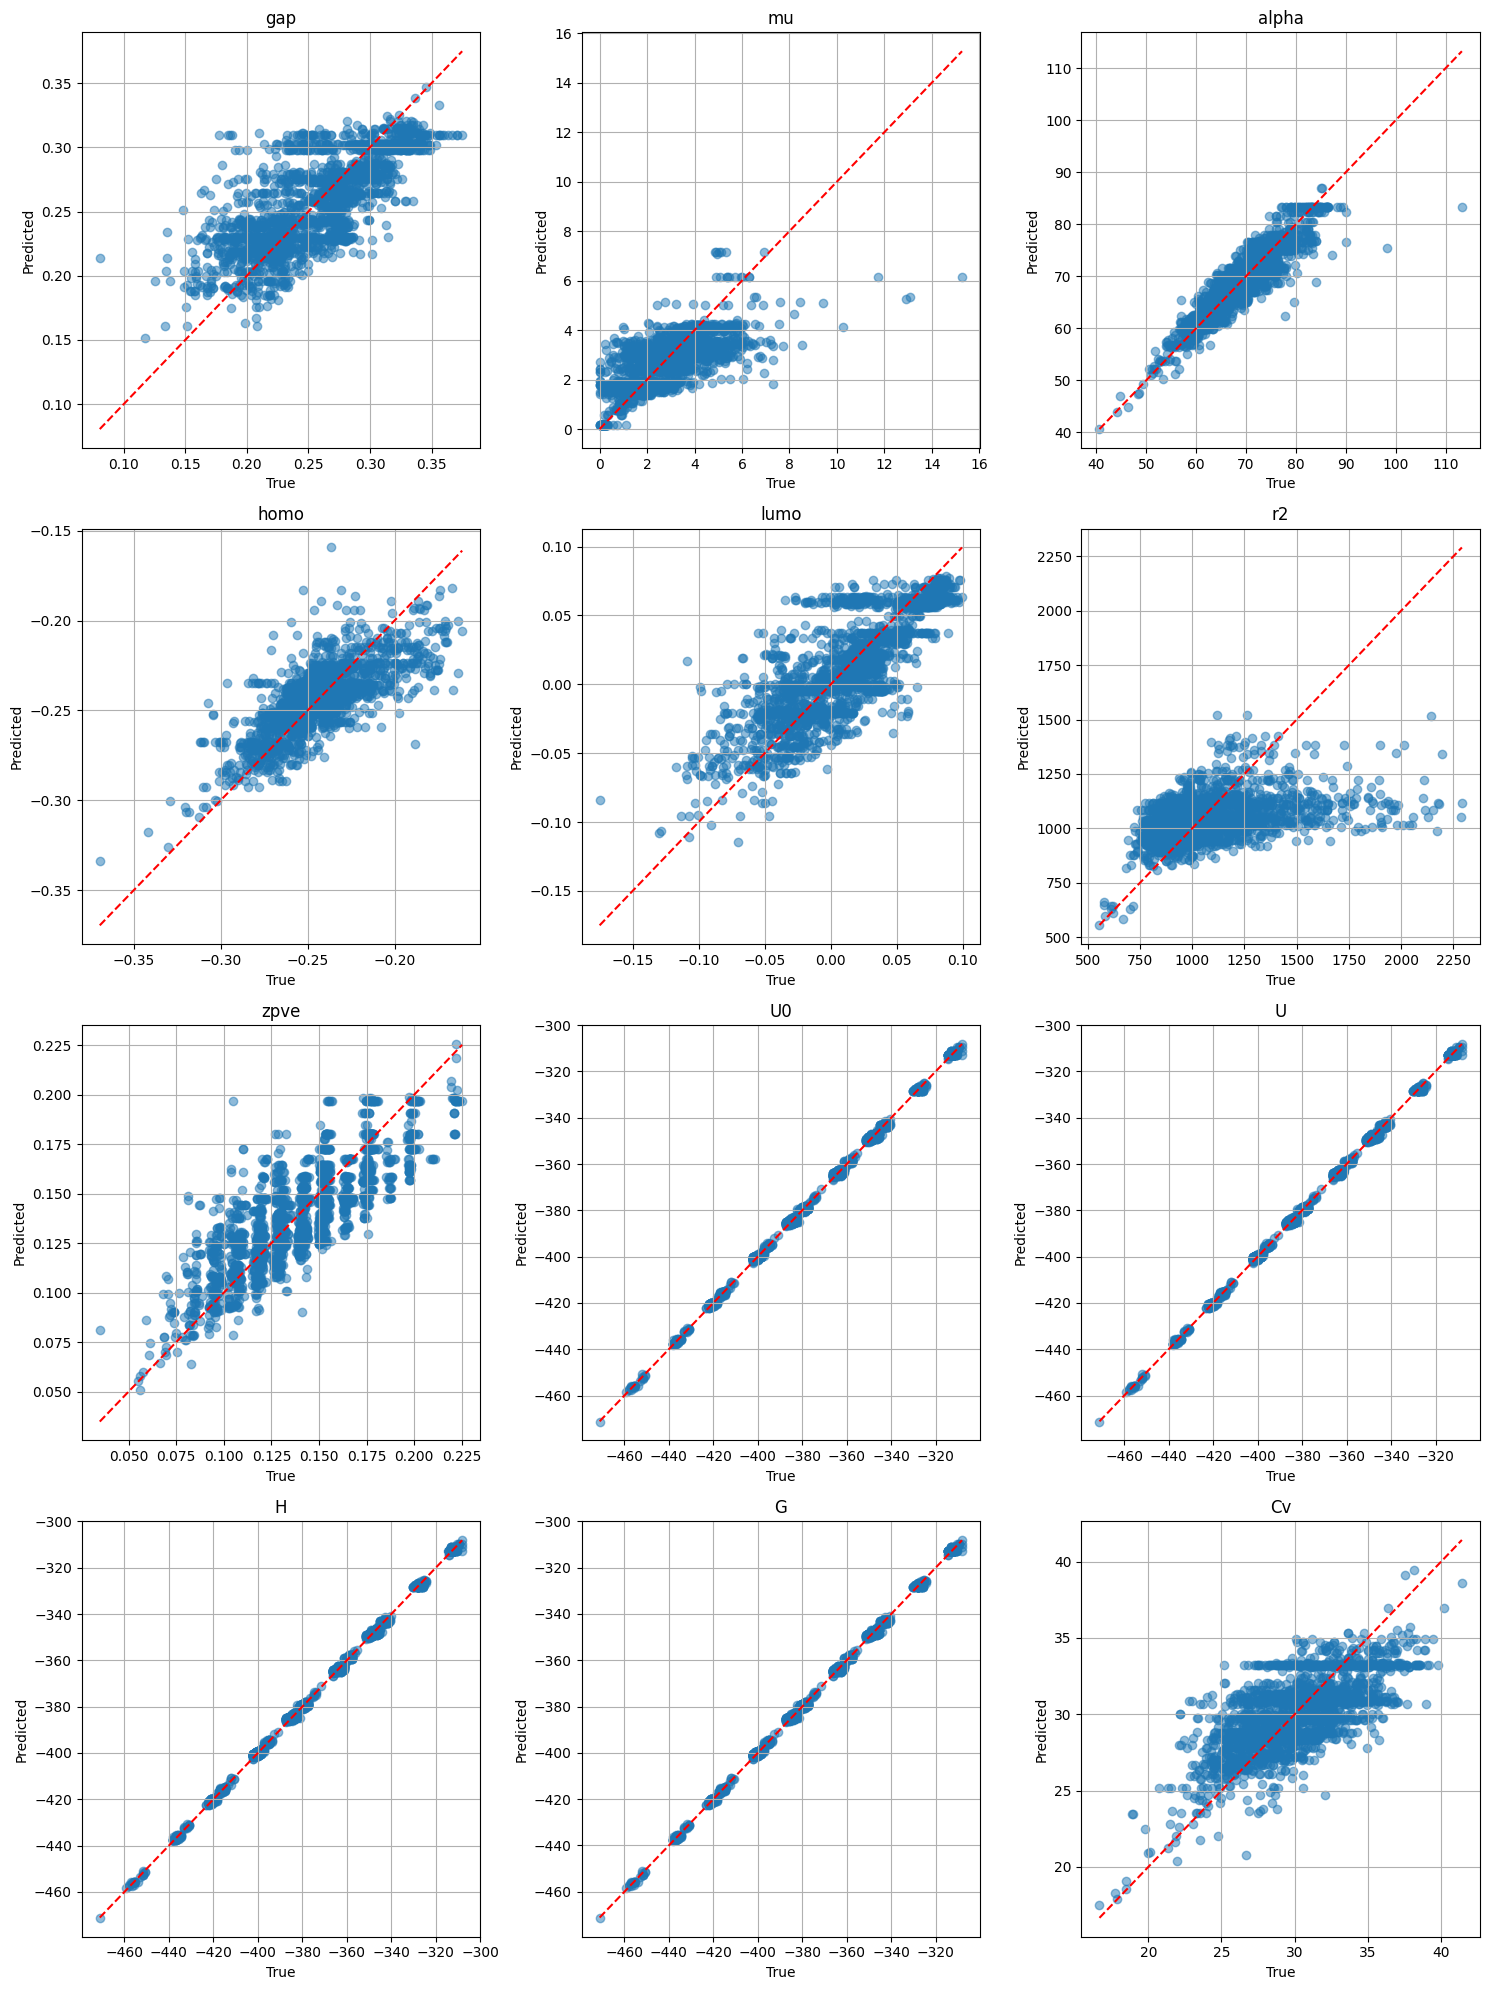

In [6]:
import matplotlib.pyplot as plt
# List of target property names
col_names = Y_te.columns.tolist()

# Number of subplot rows and columns
cols = 3
rows = int(np.ceil(len(col_names) / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes array for iteration
for i, ax in enumerate(axes.flat):
    if i < len(col_names):
        true_vals = Y_te[col_names[i]].values
        pred_vals = preds[col_names[i]].values

        ax.scatter(true_vals, pred_vals, alpha=0.5)
        ax.plot([true_vals.min(), true_vals.max()],
                [true_vals.min(), true_vals.max()], 'r--')
        ax.set_title(f"{col_names[i]}")
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.grid(True)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()